<a href="https://colab.research.google.com/github/manushaurya/padhaibyonefourthlabs/blob/master/2406_LargeCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception v3
7. Exercises

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), #resized to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #mean and variance standardized for all three channels
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #similarly for test data
    ])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, #download and transform the dataset CIFAR-10, train : true meaning trainset
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, #train :false meaning testset
                                        download=True, 
                                        transform=transform_test)

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:01, 88010283.98it/s]                               


Files already downloaded and verified


In [0]:
num_classes = 10

In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True) #dataloader defined with the batch-size and shuffle : true

In [8]:
dataiter = iter(trainloader) #iterator defined
images, labels = dataiter.next()

print(images.shape) #batch_size=4, channels=3, dimension=224x224

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
6


In [0]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5 #denormalized and converted to numpy array
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #image dimensions reshaped such that it becomes height=224,width=224,channels=3
    plt.title(title)
    plt.show()

In [0]:
def show_batch_images(dataloader): #printing batch data
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images) #grid of images
    imshow(img, title=[str(x.item()) for x in labels]) #image and title printed

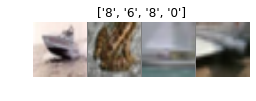

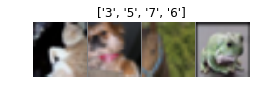

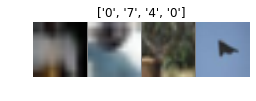

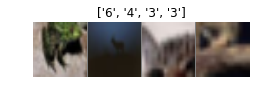

In [11]:
for i in range(4):
    show_batch_images(trainloader)

## Creating VGG-16

https://pytorch.org/docs/master/_modules/torchvision/models/vgg.html

In [0]:
from torchvision import models

In [0]:
vgg = models.vgg16_bn() #instantiating batch normalized version of VGG with 16 layers

In [14]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [15]:
print(vgg.features[0]) #features of layer indexed 0 in the VGG instance

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [16]:
print(vgg.classifier[6]) #last linear layer of the classifier

Linear(in_features=4096, out_features=1000, bias=True)


In [19]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1] #mod_classifier(modified_classifier) is now a list of all the layers/children in classifier module except last layer 
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace), Dropout(p=0.5), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace), Dropout(p=0.5), Linear(in_features=4096, out_features=10, bias=True)]


In [20]:
vgg.classifier = nn.Sequential(*mod_classifier) #VGG clasifier now contains modified classifier
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

### Train CIFAR10

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True) #trainloader with modified batch size
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1) #finding the index of largest predicted value 
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.50
Iteration: 100/3125, Loss: 2.62
Iteration: 200/3125, Loss: 2.34
Iteration: 300/3125, Loss: 2.28
Iteration: 400/3125, Loss: 2.54
Iteration: 500/3125, Loss: 2.22
Iteration: 600/3125, Loss: 2.29
Iteration: 700/3125, Loss: 2.43
Iteration: 800/3125, Loss: 2.22
Iteration: 900/3125, Loss: 2.26
Iteration: 1000/3125, Loss: 2.38
Iteration: 1100/3125, Loss: 2.28
Iteration: 1200/3125, Loss: 2.32
Iteration: 1300/3125, Loss: 2.38
Iteration: 1400/3125, Loss: 2.33
Iteration: 1500/3125, Loss: 2.25
Iteration: 1600/3125, Loss: 2.23
Iteration: 1700/3125, Loss: 2.28
Iteration: 1800/3125, Loss: 2.32
Iteration: 1900/3125, Loss: 2.30
Iteration: 2000/3125, Loss: 2.15
Iteration: 2100/3125, Loss: 2.22
Iteration: 2200/3125, Loss: 2.03
Iteration: 2300/3125, Loss: 2.10
Iteration: 2400/3125, Loss: 2.41
Iteration: 2500/3125, Loss: 2.24
Iteration: 2600/3125, Loss: 2.02
Iteration: 2700/3125, Loss: 2.37
Iteration: 2800/3125, Loss: 2.23
Iteration: 2900/3125, Loss: 1.91
Iteration: 3000/3125, 

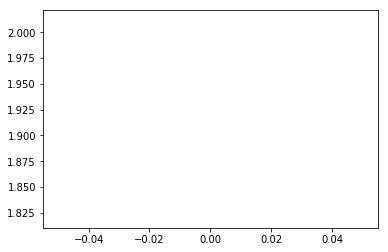

In [26]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad() #resetting gradients

        outputs = vgg(inputs) #forward pass
        loss = loss_fn(outputs, labels) #computing loss
        loss.backward() #backward pass
        opt.step() #weights updated
        
        del inputs, labels, outputs #clearing memory usage
        torch.cuda.empty_cache()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
plt.plot(loss_epoch_arr)
plt.show()

### Freeze layers of Convolutional Operations

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [28]:
vgg = models.vgg16_bn(pretrained=True) #instantiating pretrained model

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:22<00:00, 24863178.32it/s]


In [0]:
for param in vgg.parameters():
    param.requires_grad = False #no update required, thus setting requires_grad = false

In [0]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes) #last layer will have requires_grad=true

In [33]:
for param in vgg.parameters(): #proof for last comment
    if param.requires_grad:
        print(param.shape)#prints weights and bias that have requires_grad = true

torch.Size([10, 4096])
torch.Size([10])


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [35]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

KeyboardInterrupt: ignored

### With model copies

In [0]:
import copy

In [37]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item(): #allows to make deep copy best model with smallest loss
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

Min loss 1.85
Iteration: 0/3125, Loss: 1.85
Min loss 1.81
Min loss 1.71
Min loss 1.57
Min loss 0.97
Iteration: 100/3125, Loss: 1.49
Min loss 0.96
Min loss 0.85
Iteration: 200/3125, Loss: 2.28
Iteration: 300/3125, Loss: 2.74
Iteration: 400/3125, Loss: 1.99
Iteration: 500/3125, Loss: 2.17
Iteration: 600/3125, Loss: 2.48
Min loss 0.74
Iteration: 700/3125, Loss: 2.10
Min loss 0.31
Iteration: 800/3125, Loss: 3.69
Iteration: 900/3125, Loss: 1.30
Iteration: 1000/3125, Loss: 1.49
Iteration: 1100/3125, Loss: 2.87
Iteration: 1200/3125, Loss: 2.60
Iteration: 1300/3125, Loss: 1.26
Iteration: 1400/3125, Loss: 1.51
Iteration: 1500/3125, Loss: 1.86
Iteration: 1600/3125, Loss: 2.37
Iteration: 1700/3125, Loss: 2.63
Iteration: 1800/3125, Loss: 2.15
Iteration: 1900/3125, Loss: 2.75
Iteration: 2000/3125, Loss: 2.04
Iteration: 2100/3125, Loss: 2.49
Iteration: 2200/3125, Loss: 2.33
Iteration: 2300/3125, Loss: 2.35
Iteration: 2400/3125, Loss: 2.80
Iteration: 2500/3125, Loss: 1.53
Iteration: 2600/3125, Loss: 

In [38]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg)) #best model accuracy i.e with least loss

45.642 45.11


## ResNet Model

https://pytorch.org/docs/master/_modules/torchvision/models/resnet.html

In [39]:
resnet = models.resnet18(pretrained=True) #instantiating pretrained resnet-18

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 16352217.42it/s]


In [40]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
for param in resnet.parameters(): 
    param.requires_grad = False

In [0]:
in_features = resnet.fc.in_features #fc layer redefined with num_classes = 10
resnet.fc = nn.Linear(in_features, num_classes)

In [43]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

Min loss 2.78
Iteration: 0/3125, Loss: 2.78
Min loss 2.36
Min loss 2.22
Min loss 2.11
Min loss 1.94
Min loss 1.93
Min loss 1.84
Min loss 1.67
Min loss 1.61
Min loss 1.55
Iteration: 100/3125, Loss: 1.92
Min loss 1.44
Min loss 1.41
Min loss 1.32
Min loss 1.31
Iteration: 200/3125, Loss: 1.81
Min loss 1.26
Min loss 1.16
Iteration: 300/3125, Loss: 1.39
Min loss 1.13
Min loss 1.00
Iteration: 400/3125, Loss: 1.73
Min loss 1.00
Min loss 1.00
Iteration: 500/3125, Loss: 1.85
Min loss 0.86
Min loss 0.86
Iteration: 600/3125, Loss: 1.45
Iteration: 700/3125, Loss: 1.08
Min loss 0.81
Iteration: 800/3125, Loss: 1.55
Min loss 0.69
Iteration: 900/3125, Loss: 1.16
Iteration: 1000/3125, Loss: 1.10
Iteration: 1100/3125, Loss: 1.37
Iteration: 1200/3125, Loss: 1.08
Iteration: 1300/3125, Loss: 0.86
Iteration: 1400/3125, Loss: 1.16
Iteration: 1500/3125, Loss: 2.11
Min loss 0.68
Iteration: 1600/3125, Loss: 1.38
Iteration: 1700/3125, Loss: 1.06
Iteration: 1800/3125, Loss: 1.28
Iteration: 1900/3125, Loss: 1.12
Mi

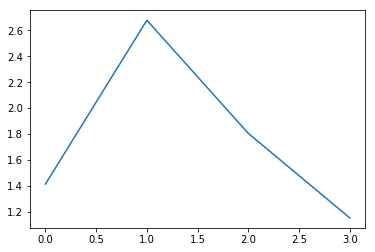

In [45]:
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [46]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

56.926 56.69


## Inception Model

https://pytorch.org/docs/master/_modules/torchvision/models/inception.html

In [47]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:01<00:00, 58776630.02it/s]


In [48]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [0]:
for param in inception.parameters():
    param.requires_grad = False

In [0]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [52]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [0]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [54]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299),  #model takes 299x299
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), #similar transform
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [58]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [0]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs) #model returns a tuple of output and auxiliary output
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 3.13
Iteration: 0/3125, Loss: 3.13
Min loss 3.08
Min loss 3.00
Min loss 2.89
Min loss 2.88
Min loss 2.81
Min loss 2.68
Min loss 2.68
Min loss 2.59
Min loss 2.54
Iteration: 100/3125, Loss: 2.75
Min loss 2.42
Min loss 2.38
Min loss 2.36
Min loss 2.29
Min loss 2.22
Iteration: 200/3125, Loss: 2.59
Min loss 2.18
Min loss 2.17
Min loss 2.16
Min loss 2.14
Min loss 2.03
Iteration: 300/3125, Loss: 2.15
Min loss 2.00
Min loss 1.85
Iteration: 400/3125, Loss: 1.85
Min loss 1.78
Iteration: 500/3125, Loss: 2.24
Min loss 1.73
Iteration: 600/3125, Loss: 2.09
Min loss 1.71
Min loss 1.61
Iteration: 700/3125, Loss: 1.94
Min loss 1.59
Iteration: 800/3125, Loss: 1.59
Min loss 1.53
Iteration: 900/3125, Loss: 2.02
Min loss 1.51
Min loss 1.50
Min loss 1.38
Iteration: 1000/3125, Loss: 1.73
Iteration: 1100/3125, Loss: 1.72
Iteration: 1200/3125, Loss: 2.49
Min loss 1.35
Iteration: 1300/3125, Loss: 2.18
Min loss 1.28
Iteration: 1400/3125, Loss: 2.05
Iteration: 1500/3125, Loss: 1.94
Iteration: 1600/3125, 

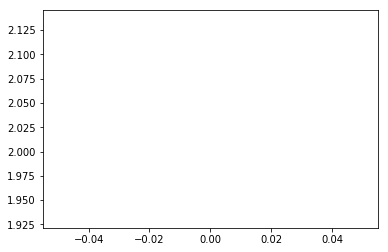

In [62]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels) #major change in loss computation
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [63]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

46.354 46.78


## Exercises

1. Structure the above code into a series of functions and then call each model

2. Try out different hyperparameter combinations and try to achieve published results on different networks

3. Try out the CIFAR100 and STL10 datasets

4. Try out another model - SqueezeNet

5. Try training multiple layers and not just the last one